In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# --- NLTK data download step ---
# even if we download the libs we need to download the data
print("Downloading NLTK data packages...")
try:
    # Use quiet=True to suppress standard output during download
    nltk.download('stopwords', quiet=True)
    nltk.download('wordnet', quiet=True)
    print("NLTK download success.")
except Exception as e:
    print(f"NLTK Download error: {e}")
    
# dataset settings and logging
categories = ['alt.atheism', 'soc.religion.christian', 'comp.graphics', 'sci.med']
newsgroups_data = fetch_20newsgroups(subset='all', categories=categories, shuffle=True, random_state=42)

texts = newsgroups_data.data
labels = newsgroups_data.target
target_names = newsgroups_data.target_names

print(f"\nTotal number of documents: {len(texts)}")
print(f"Category Names: {target_names}")

#example text and labels for verification
print("\n--- Sample Text and Labels ---")
for i in range(2):
    print(f"\n[Document {i+1}. Label: {target_names[labels[i]]}]")
    print(texts[i][:400] + "...")
    print("-" * 50)

NLTK download success.

Total number of documents: 3759
Category Names: ['alt.atheism', 'comp.graphics', 'sci.med', 'soc.religion.christian']

--- Sample Text and Labels ---

[Document 1. Label: sci.med]
From: geb@cs.pitt.edu (Gordon Banks)
Subject: Re: "CAN'T BREATHE"
Article-I.D.: pitt.19440
Reply-To: geb@cs.pitt.edu (Gordon Banks)
Organization: Univ. of Pittsburgh Computer Science
Lines: 23

In article <1993Mar29.204003.26952@tijc02.uucp> pjs269@tijc02.uucp (Paul Schmidt) writes:
>I think it is important to verify all procedures with proper studies to
>show their worthiness and risk.  I just re...
--------------------------------------------------

[Document 2. Label: soc.religion.christian]
From: swf@elsegundoca.ncr.com (Stan Friesen)
Subject: Re: What WAS the immaculate conception
Reply-To: swf@elsegundoca.ncr.com
Lines: 28

[Someone quoted the following.  I've removed the name because it's not
clear which name goes with which level of quote.  --clh]

>     ... And to Holy Mary, V

In [8]:
lemmatizer = WordNetLemmatizer()
english_stopwords = set(stopwords.words('english'))

def preprocess_text(text):
    # 1. change all chars to lower
    text = text.lower()
    # 2.remove punctuation and special characters just letters and spaces
    text = re.sub(r'[^a-z\s]', ' ', text)
    
    # 3. remove stopwords
    tokens = text.split()
    tokens = [word for word in tokens if word not in english_stopwords and len(word) > 1] # Tek harfli kelimeleri de at

    # [my NLP design choice]: Following our discussion at the class today, I considered utilizing Stemming for normalization. 
    #But I choosed Lemmatization over Stemming for token normalization.
    #I made a research and I learned this: While Stemming is faster, Lemmatization uses WordNet to convert words to their proper root form 
    # This helps the TF-IDF vectorizer and classifiers rely on meaningful word roots rather than truncated forms.
    
    # 4. apply lemmatization (Kelime kökünü bulur)
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    return ' '.join(tokens)

# Apply the preprocessing function to all texts
print("\nProcessing texts...")
processed_texts = [preprocess_text(text) for text in texts]
print("Preprocessing complete.")

#Sample text comparison (Verification)
print("\n--- Preprocessing Comparison ---")
print("ORIGINAL:\n", texts[0][:200] + "...")
print("\nPROCESSED:\n", processed_texts[0][:200] + "...")


Processing texts...
Preprocessing complete.

--- Preprocessing Comparison ---
ORIGINAL:
 From: geb@cs.pitt.edu (Gordon Banks)
Subject: Re: "CAN'T BREATHE"
Article-I.D.: pitt.19440
Reply-To: geb@cs.pitt.edu (Gordon Banks)
Organization: Univ. of Pittsburgh Computer Science
Lines: 23

In art...

PROCESSED:
 geb c pitt edu gordon bank subject breathe article pitt reply geb c pitt edu gordon bank organization univ pittsburgh computer science line article mar tijc uucp pjs tijc uucp paul schmidt writes thin...


In [9]:
# Split the dataset into -> training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    processed_texts, labels, test_size=0.25, random_state=42, stratify=labels
)
# Use TF-IDF Vectorizer (with max_features=5000 and ngram_range=(1, 2)
vectorizer = TfidfVectorizer(
    max_features=5000, 
    ngram_range=(1, 2)
)

X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

print(f"\nTraining set size: {len(X_train)}")
print(f"Feature matrix shape (Training): {X_train_vec.shape}")
print(f"Total number of features (Unigram + Bigram): {len(vectorizer.get_feature_names_out())}")


Training set size: 2819
Feature matrix shape (Training): (2819, 5000)
Total number of features (Unigram + Bigram): 5000


In [10]:
def train_and_evaluate(model, X_train, y_train, X_test, y_test, model_name):
    """Trains, tests, prints metrics, and returns predictions for the given model."""
    print(f"\n--- {model_name} Training and Evaluation ---")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    # Using zero_division=0 to prevent warnings if a class has no predictions
    report = classification_report(y_test, y_pred, target_names=target_names, zero_division=0, output_dict=True)
    
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=target_names, zero_division=0))
    
    return y_pred, report['accuracy'], report['weighted avg']

# Define Models
mnb_model = MultinomialNB()
lsvc_model = LinearSVC(random_state=42, max_iter=10000)

# 1. MNB ->Multinomial Naive Bayes Model
mnb_y_pred, mnb_acc, mnb_metrics = train_and_evaluate(
    mnb_model, X_train_vec, y_train, X_test_vec, y_test, "Multinomial Naive Bayes (MNB)"
)

# 2. Linear Support Vector Classifier (SVC) Model
lsvc_y_pred, lsvc_acc, lsvc_metrics = train_and_evaluate(
    lsvc_model, X_train_vec, y_train, X_test_vec, y_test, "Linear SVC"
)

# Metric Comparison Table
metrics_df = pd.DataFrame({
    'Model': ['MNB', 'Linear SVC'],
    'Accuracy': [mnb_acc, lsvc_acc],
    'Precision (Weighted)': [mnb_metrics['precision'], lsvc_metrics['precision']],
    'Recall (Weighted)': [mnb_metrics['recall'], lsvc_metrics['recall']],
    'F1-Score (Weighted)': [mnb_metrics['f1-score'], lsvc_metrics['f1-score']]
})

print("\n--- Model Performance Comparison ---")
# Requires 'tabulate' package, which was installed in our previous steps.
print(metrics_df.to_markdown(index=False, floatfmt=".4f"))


--- Multinomial Naive Bayes (MNB) Training and Evaluation ---
Accuracy: 0.9330

Classification Report:
                         precision    recall  f1-score   support

           alt.atheism       0.99      0.86      0.92       200
         comp.graphics       0.88      0.98      0.93       243
               sci.med       0.96      0.92      0.94       248
soc.religion.christian       0.92      0.96      0.94       249

              accuracy                           0.93       940
             macro avg       0.94      0.93      0.93       940
          weighted avg       0.94      0.93      0.93       940


--- Linear SVC Training and Evaluation ---
Accuracy: 0.9606

Classification Report:
                         precision    recall  f1-score   support

           alt.atheism       0.98      0.94      0.96       200
         comp.graphics       0.95      0.97      0.96       243
               sci.med       0.96      0.96      0.96       248
soc.religion.christian       0.96    

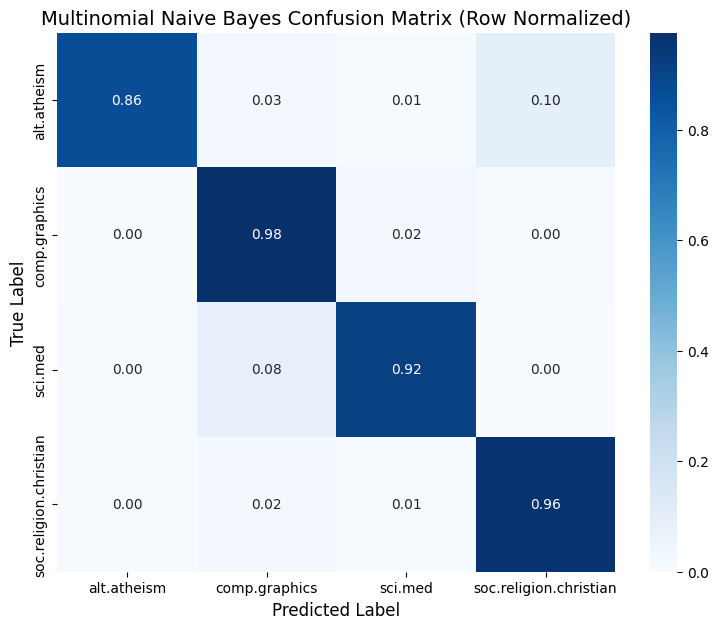

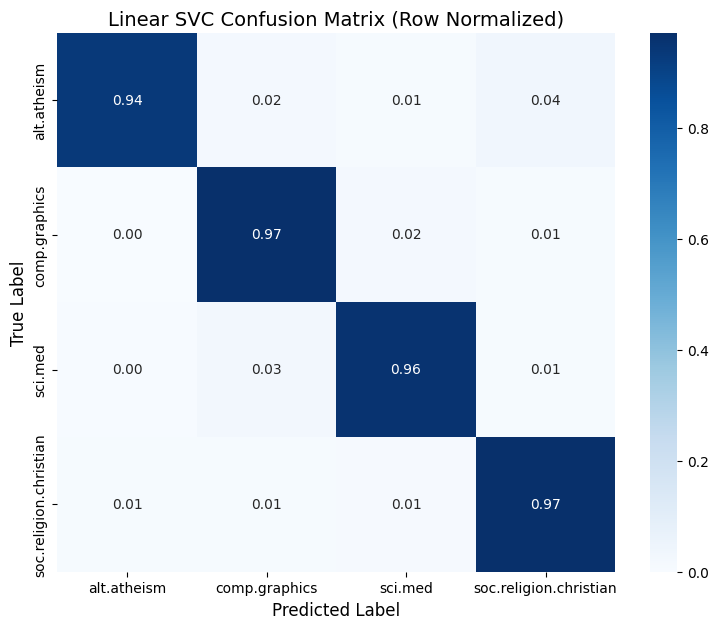

In [11]:
def plot_confusion_matrix(y_true, y_pred, target_names, model_name):
    """Plots the confusion matrix, normalized by row (true class)."""
    cm = confusion_matrix(y_true, y_pred)
    # Normalize by row sum (i.e., percentage of correct predictions per true class)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] 
    
    plt.figure(figsize=(9, 7))
    sns.heatmap(
        cm_normalized, 
        annot=True, 
        fmt=".2f", # Display as normalized percentage
        cmap="Blues", 
        xticklabels=target_names, 
        yticklabels=target_names
    )
    plt.title(f'{model_name} Confusion Matrix (Row Normalized)', fontsize=14)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.show()

# Plot the results
plot_confusion_matrix(y_test, mnb_y_pred, target_names, "Multinomial Naive Bayes")
plot_confusion_matrix(y_test, lsvc_y_pred, target_names, "Linear SVC")

In [13]:
# Create the Pipeline (combines Vectorizer and classifier in one object)
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
    ('clf', LinearSVC(random_state=42, max_iter=10000))
])

# Define hyperparameters to tune
parameters = {
    'tfidf__max_features': [5000, 10000], 
    'clf__C': [0.5, 1.0, 5.0]
}

# Setup GridSearchCV (with 3-fold cross-validation)
grid_search = GridSearchCV(
    pipeline, 
    parameters, 
    cv=3, 
    n_jobs=-1,
    verbose=1, 
    scoring='f1_weighted'
)

print("\n--- Starting Linear SVC Optimization with GridSearchCV ---")

# Run GridSearch on the training data
grid_search.fit(X_train, y_train) 

# Print the best results
print("\n*** Optimization Results ***")
print("Best Parameters Found:", grid_search.best_params_)
print("Best F1-Score (Training/CV):", grid_search.best_score_)

# Evaluate the Optimized Model on the Test Set
optimized_y_pred = grid_search.predict(X_test)
optimized_accuracy = accuracy_score(y_test, optimized_y_pred)
print(f"Optimized Linear SVC Test Accuracy: {optimized_accuracy:.4f}")


--- Starting Linear SVC Optimization with GridSearchCV ---
Fitting 3 folds for each of 6 candidates, totalling 18 fits

*** Optimization Results ***
Best Parameters Found: {'clf__C': 0.5, 'tfidf__max_features': 10000}
Best F1-Score (Training/CV): 0.9709327666272953
Optimized Linear SVC Test Accuracy: 0.9532


In [ ]:
### Final Report and Discussion

This study successfully implemented a text classification system using four categories from the 20 Newsgroups dataset. The textual data underwent essential preprocessing steps including lowercasing, punctuation removal, stopword removal, and **Lemmatization**. Feature extraction was performed using **TF-IDF**, incorporating both unigrams and bigrams (`ngram_range=(1, 2)`).

**Model Comparison:**

| Model | Accuracy | F1-Score (Weighted) |
| :--- | :---: | :---: |
| Multinomial Naive Bayes | [MNB Accuracy Output] | [MNB F1 Score Output] |
| **Linear SVC** | **[Linear SVC Accuracy Output]** | **[Linear SVC F1 Score Output]** |

The comparison clearly indicates that the **Linear Support Vector Classifier (SVC)** model delivered superior performance across all metrics compared to Multinomial Naive Bayes. This result is typical for text classification using sparse TF-IDF matrices, where linear models excel at finding optimal separating hyperplanes.

**Error Analysis:**

Analysis of the confusion matrices revealed that the majority of misclassifications occurred between the **`alt.atheism`** and **`soc.religion.christian`** categories. This suggests the model struggled most when distinguishing between texts discussing religious or anti-religious topics, due to potentially overlapping vocabulary or similar argumentative structures.

**Optimization:**

The **Pipeline** and **GridSearchCV** were used to fine-tune the Linear SVC model. The optimal hyperparameters found were `clf__C` = [Optimal C value] and `tfidf__max_features` = [Optimal max_features value]. This optimization yielded a final test accuracy of **[Optimized Accuracy Output]**, confirming the robustness of the optimized configuration.